In [1]:
from brian2 import *
from DynapSE import DynapSE
from SpikeGen import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings/dynapse-simulator-New-Parameters/

BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

In [2]:
def SFA(ampa_conf,adaptation_conf):    
    device.reinit()
    device.activate()
    defaultclock.dt = 20 * us

    ## Observing Adaptation Effect
    ##################

 
  

    freq_list=[200,300,500,1000]*Hz
    inp_duration=1

    # Create a Brian2 network and chip instance and neurons-
    network = Network()
    chip = DynapSE(network)
    DPI_neurons  = chip.get_neurons(len(freq_list), 'Core_1')

    DPI_synapses=[]
    Spike_Generators=[]
    counter1=0
    counter2=1

    # Connect a single spike generator to a single DPI neuron 
    for i in range(len(freq_list)):
        #SpikeGen(input_type,start,end,duration,freq,numberofinstances,name)
        Spike_Generators.append(SpikeGen('regular',0,1,1,freq_list[i],1,'SpikeGenerator'+str(i)))
        DPI_synapses.append(chip.add_connection(Spike_Generators[i],DPI_neurons[counter1:counter2], synapse_type='AMPA'))
        chip.connect(DPI_synapses[i], True)
        DPI_synapses[i].weight = 1
        
        counter1=counter1+1
        counter2=counter2+1
        


    # merge the param dict into 1.
    core_conf = {**ampa_conf,**adaptation_conf}
    # set the params
    chip.set_bias(core_conf, 'Core_1')

    # Monitors
    mon_neuron_output_1 = SpikeMonitor(DPI_neurons[0:1], name='mon_neuron_output_1',record=True)
    mon_neuron_output_2 = SpikeMonitor(DPI_neurons[1:2], name='mon_neuron_output_2',record=True)
    mon_neuron_output_3 = SpikeMonitor(DPI_neurons[2:3], name='mon_neuron_output_3',record=True)
    mon_neuron_output_4 = SpikeMonitor(DPI_neurons[3:4], name='mon_neuron_output_4',record=True)
    mon_synapse_ampa  = StateMonitor(DPI_synapses[0], 'Iampa', record=[0])
    mon_synapse_ampa  = StateMonitor(DPI_synapses[1], 'Iampa', record=[0])
    mon_synapse_ampa  = StateMonitor(DPI_synapses[2], 'Iampa', record=[0])
    mon_synapse_ampa  = StateMonitor(DPI_synapses[3], 'Iampa', record=[0])
    mon_adapt_state  = StateMonitor(DPI_neurons,  'Isoma_ahp', record=True)
    mon_mem_state = StateMonitor(DPI_neurons,  'Isoma_mem', record=True)
    network.add([Spike_Generators, DPI_neurons, DPI_synapses,mon_synapse_ampa,mon_adapt_state,mon_mem_state])
    network.add([mon_neuron_output_1,mon_neuron_output_2,mon_neuron_output_3,mon_neuron_output_4])
    # Simulation
    network.run(inp_duration * 1000 * ms)
    return mon_adapt_state,mon_mem_state,mon_neuron_output_1,mon_neuron_output_2,mon_neuron_output_3,mon_neuron_output_4


In [3]:
def graph_SFA_Full(mon_adapt_state,mon_mem_state,o1,o2,o3,o4):
    
    fig1, (ax) = plt.subplots(1, 1,figsize=(12,4),dpi=150)
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[0].Isoma_ahp/pA,label='ISI 200 Hz')
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[1].Isoma_ahp/pA,label='ISI 300 Hz')
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[2].Isoma_ahp/pA,label='ISI 500 Hz')
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[3].Isoma_ahp/pA,label='ISI 1000 Hz')
    ax.set_title('SFA')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Current (PA)')
    ax.legend()

    # plotting
    plt.figure(figsize=(12,4),dpi=150)
    plt.subplots_adjust(hspace=2)
    plt.subplot(4,1,1)

    plot(mon_mem_state.t/ms,mon_mem_state[0].Isoma_mem/pA ,linewidth=1.5,label='$I_{mem}$ 200 Hz')
    plt.title('$I_{mem}$ 200 Hz')
    plt.ylabel('Current (A)')
    #plt.legend(loc='upper right')

    plt.subplot(4,1,2)

    plot(mon_adapt_state.t/ms,mon_mem_state[1].Isoma_mem/pA, linewidth=1.5,label='$I_{mem}$ 300 Hz')
    plt.title('$I_{mem}$ 300 Hz')
    plt.ylabel('Current (A)')
    #plt.legend(loc='upper right')

    plt.subplot(4,1,3)
    plot(mon_adapt_state.t/ms,mon_mem_state[2].Isoma_mem/pA, linewidth=1.5,label='$I_{mem}$ 500 Hz')
    plt.title('$I_{mem}$ 500 Hz')
    plt.ylabel('Current (A)')
    #plt.legend(loc='upper right')

    plt.subplot(4,1,4)
    plot(mon_adapt_state.t/ms,mon_mem_state[3].Isoma_mem/pA, linewidth=1.5,label='$I_{mem}$ 1000 Hz')
    plt.title('$I_{mem}$ 1000 Hz')
    plt.ylabel('Current (A)')
    #plt.legend(loc='upper right')
    plt.xlabel('Time (ms)')

    fig2, (ax1,ax2) = plt.subplots(1, 2,figsize=(24,6))
    ax1.plot(np.diff(o1.t/ms),'o',label='ISI 200 Hz')
    ax1.plot(np.diff(o2.t/ms),'o',label='ISI 300 Hz')
    ax1.plot(np.diff(o3.t/ms),'o',label='ISI 500 Hz')
    ax1.plot(np.diff(o4.t/ms),'o',label='ISI 1000 Hz')
    ax1.set_title('SFA')
    ax1.set_xlabel('Spike number')
    ax1.set_ylabel('Output ISI (ms)')
    ax1.legend()
    ax1.grid()

    ax2.plot(remove_last_element(np.array(o1.t/ms)),1/(np.diff(o1.t)),label='ISI 200 Hz')
    ax2.plot(remove_last_element(np.array(o2.t/ms)),1/(np.diff(o2.t)),label='ISI 300 Hz')
    ax2.plot(remove_last_element(np.array(o3.t/ms)),1/(np.diff(o3.t)),label='ISI 500 Hz')
    ax2.plot(remove_last_element(np.array(o4.t/ms)),1/(np.diff(o4.t)),label='ISI 1000 Hz')
    ax2.set_title('Frequency vs Spike number')
    ax2.set_xlabel('Spike number')
    ax2.set_ylabel('Frequency(hz)')
    ax2.legend()

    plt.grid(True)

In [4]:
def remove_last_element(arr):
    return arr[np.arange(arr.size - 1)]

4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


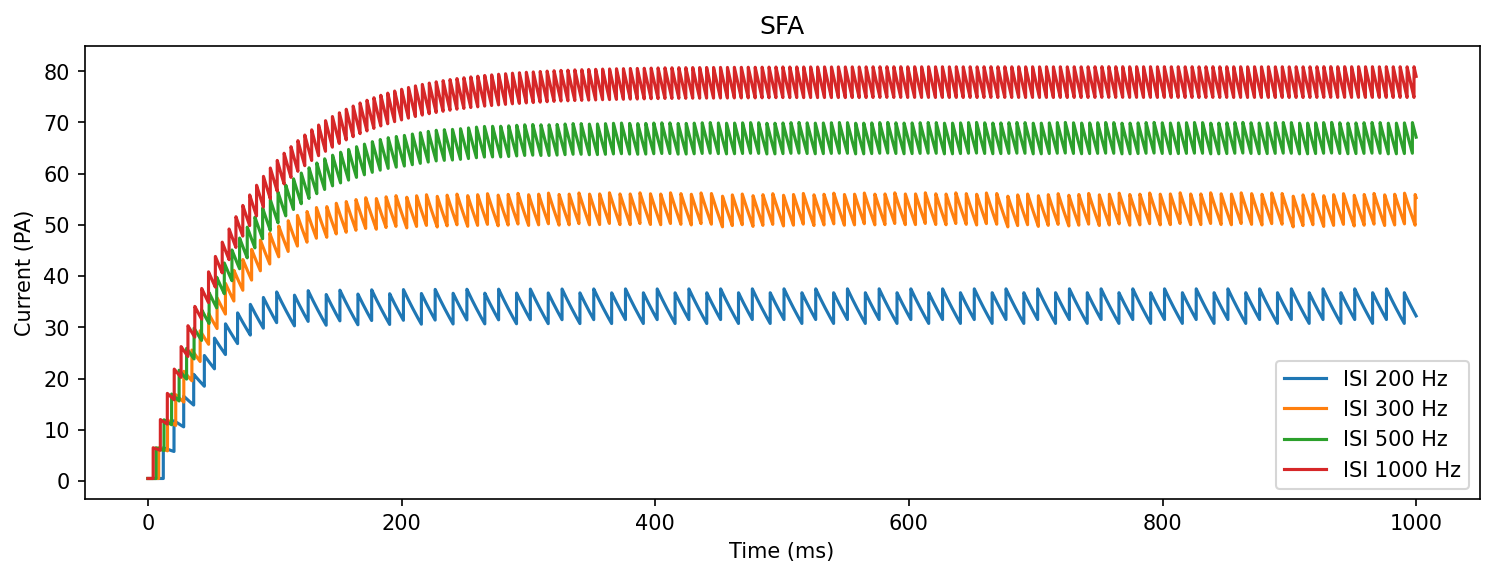

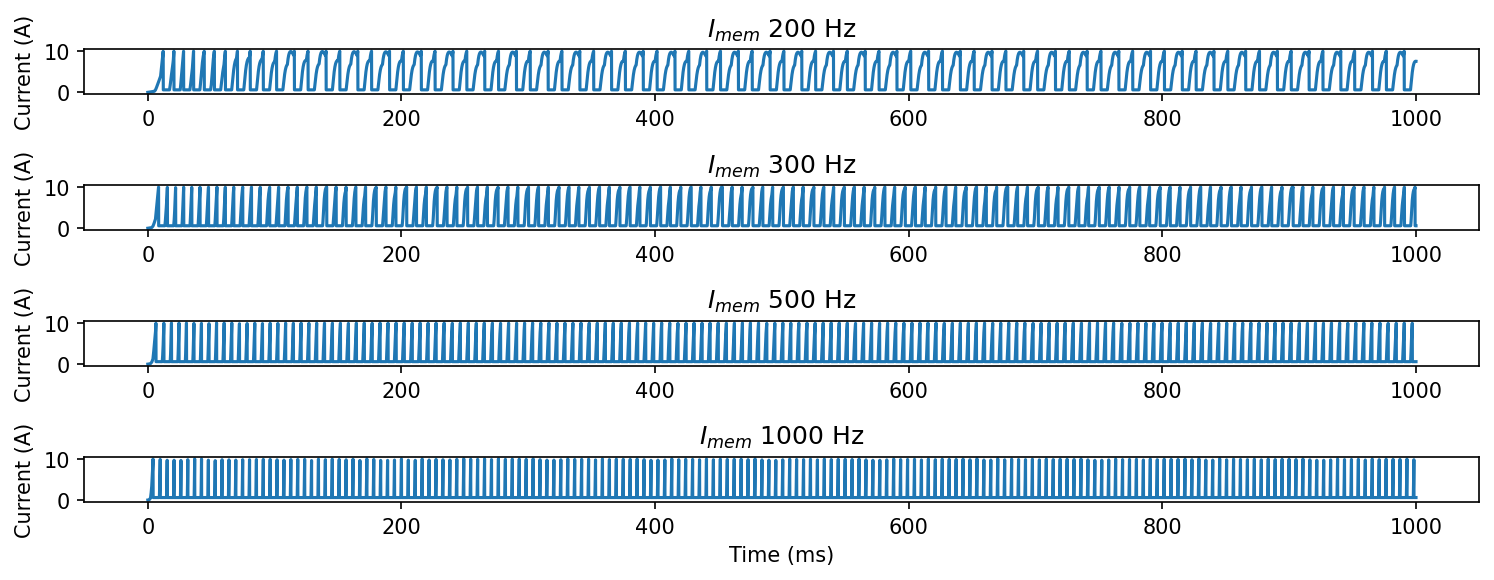

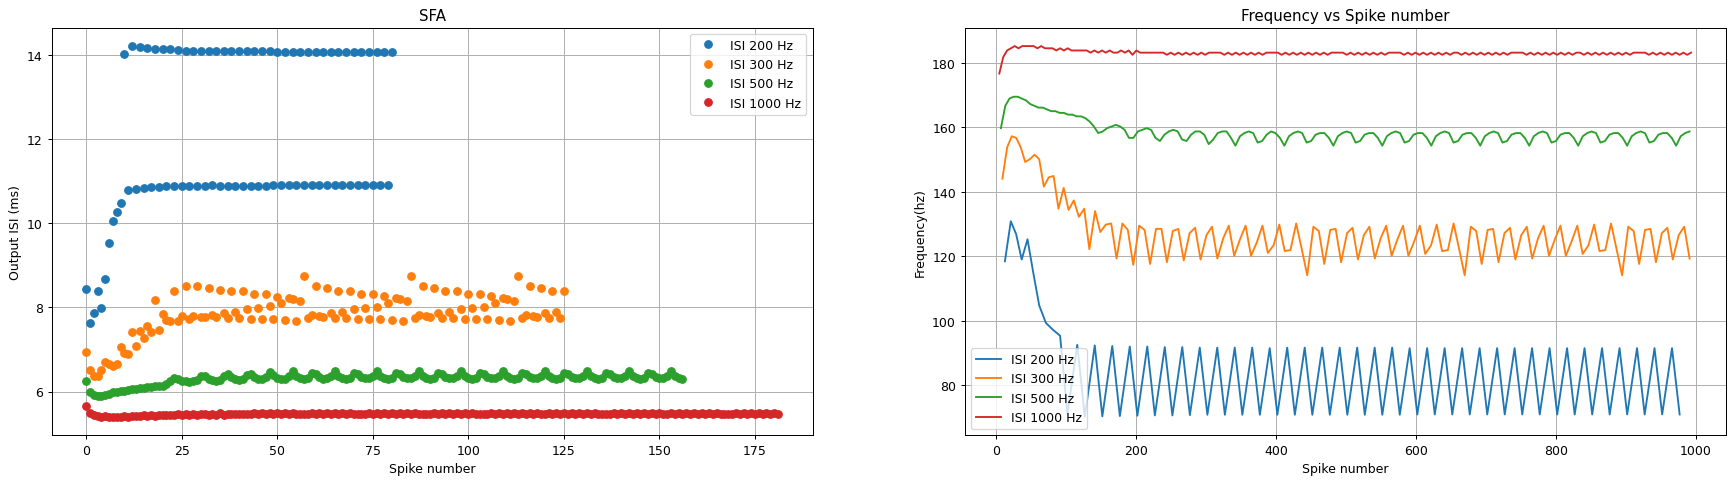

In [9]:
import math

import matplotlib.pyplot as plt
from matplotlib import gridspec




adaptation_conf = {
                   "Isoma_dpi_tau" : 2 * pA,
                   "Isoma_th"  : 10 * pA,                   
                   "Isoma_ahp_tau": 0.5 * pA,                 
                   "Isoma_ahp_th": .5 * pA,
                   "Isoma_ahp_w" : 6 * pA
                  }

ampa_conf = {"Iampa_tau": 5 * pA,
            "alpha": 1,
            "Iampa_w0": 100 * pA}




[mon_adapt_state,mon_mem_state,o1,o2,o3,o4]=SFA(ampa_conf,adaptation_conf)
graph_SFA_Full(mon_adapt_state,mon_mem_state,o1,o2,o3,o4)

# Plotting output ISI


In [6]:
# Add code here
# to start a new build to run multiple full simulations
device.reinit()
device.activate()
# need to reset the defaultclock after activate
defaultclock.dt = 20 * us
network = Network()
chip = DynapSE(network)
seed(4321)
# Create a poisson spike generator with 100 Hz





# Allocate Neurons

N=1
Neuron1 = chip.get_neurons(N, 'Core_1') #EXITATORY

# Define SYNAPSES




#CORE configurations 
#CORE 1


ampa_conf = {"Iampa_tau": 5 * pA,
            "Iampa": 5 * pA,
            "Iampa_w0": 100 * pA}


adaptation_conf = {
                   "Isoma_const" : 300 * pA,
                   "Isoma_dpi_tau" : 1 * pA,
                   "Isoma_th"  : 30 * pA,                   
                   "Isoma_ahp_tau": 0.5 * pA,                 
                   "Isoma_ahp_th": 1 * pA,
                   "Isoma_ahp_w" : 3 * pA
                  }




# merge the param dict into 1.
core_conf = {**ampa_conf,**adaptation_conf}
# set the params
chip.set_bias(core_conf, 'Core_1')
# MONITORS
mon_synapse1_state = StateMonitor(DPI_synapse, 'Iampa', record=[0])

mon_neuron_state1  = StateMonitor(Neuron1,  'Isoma_mem', record=True)

mon_Stimulus  = SpikeMonitor(Stimulus, name='mon_Stimulus')

mon_neuron_output1 = SpikeMonitor(Neuron1, name='mon_neuron_output1',record=True)



# add all the instances into the network
network.add([Stimulus])
network.add([mon_neuron_state1,mon_Stimulus,mon_neuron_output1])
network.run(inp_duration*second)


1 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


NameError: name 'DPI_synapse' is not defined